# Model Evaluation and Predictions 

For evaluating and generate predicted masks of V-Unet and X-Unet

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
%cd /content/gdrive/MyDrive/Lung_Segmentation

/content/gdrive/MyDrive/Lung_Segmentation


In [26]:
from DataPreprocessing import adjust_data, train_generator
from ValidationAndPrediction import *
from Model import dice_coef, dice_coef_loss, iou
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.models import Model,load_model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

**Default testset for evaluation:** `Default_testset.csv`

In [27]:
test_df = pd.read_csv('Default_testset.csv')

# Delete the first column that store the index from data list
test_df.drop(test_df.columns[0], axis=1, inplace=True)
display(test_df)

,filename,mask
0,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
1,Lung_seg_data/NEW_TIF_IMG/img_lung_pos3_445.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos3_445.tif
2,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_935.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_935.tif
3,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_435.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_435.tif
4,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_225.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_225.tif
...,...,...
75,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
76,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
77,Lung_seg_data/NEW_CODES/newcode_gen_images/img...,Lung_seg_data/NEW_CODES/newcode_gen_masks/mask...
78,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_410.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_410.tif


In [28]:
batch_size = 20
height = 256
width = 256

# 1. Evaluating V-Unet
## 1.1. V-Unet v1_1 (pre-train and FT with 400 LUS) 
Using `evaluate_generator` to evaluate the model performances 

**Transfer learning model**:

In [ ]:
TLmodel_path = 'model_v1_1/unet_lung_segmentation.hdf5'
TLmodel = load_model(TLmodel_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
TLmodel.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))

val_loss, val_iou, val_dice, val_accuracy = TLmodel.evaluate_generator(evaluate_gen, 
                                                steps=len(test_df)//batch_size,
                                                verbose=1)

print('Evaluation scores from V-Unet TL model:')
print('Validation loss: ', val_loss)
print('Validation dice coefficient: ', val_dice)
print('Validation iou: ', val_iou)
print('Validation accuracy: ', val_accuracy)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 134s 33s/step - loss: -0.8200 - iou: 0.6950 - dice_coef: 0.8200 - binary_accuracy: 0.9926
Evaluation scores from V-Unet TL model:
Validation loss:  -0.8199636340141296
Validation dice coefficient:  0.8199636936187744
Validation iou:  0.6949967741966248
Validation accuracy:  0.9926233291625977


Predicted mask examples: 

Testing image 1 : 73


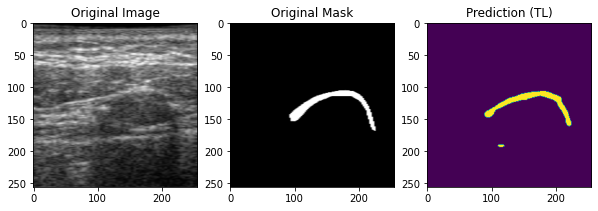

Testing image 2 : 1


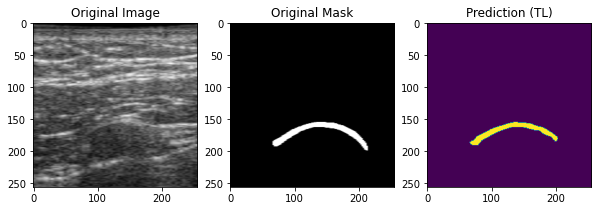

Testing image 3 : 9


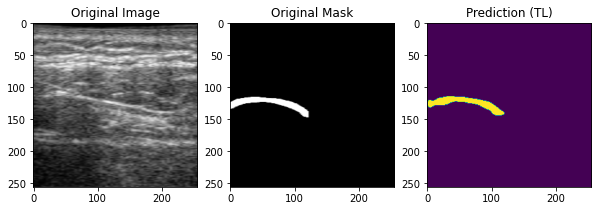

Testing image 4 : 64


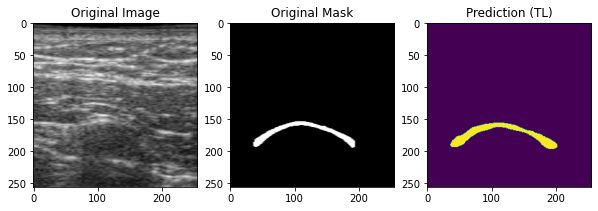

Testing image 5 : 23


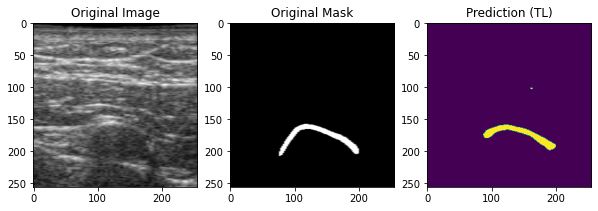

In [ ]:
pred_results_tl(TLmodel, test_df, 5, height, width)

**Fine-tuning models (5Fold):**

In [ ]:
KFmodel_path = 'model_v1_1/1_KFold_ft_unet_lung_segmentation_new.hdf5'
KFmodel = load_model(KFmodel_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))

val_loss, val_iou, val_dice, val_accuracy = KFmodel.evaluate_generator(evaluate_gen, 
                                                steps=len(test_df)//batch_size,
                                                verbose=1)

print('Evaluation scores from V-Unet FT model:')
print('Validation loss: ', val_loss)
print('Validation dice coefficient: ', val_dice)
print('Validation iou: ', val_iou)
print('Validation accuracy: ', val_accuracy)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 132s 33s/step - loss: -0.8560 - iou: 0.7484 - dice_coef: 0.8560 - binary_accuracy: 0.9937
Evaluation scores from V-Unet FT model:
Validation loss:  -0.8559977412223816
Validation dice coefficient:  0.8559978008270264
Validation iou:  0.7483587861061096
Validation accuracy:  0.993747889995575


In [ ]:
KFmodel_path = 'model_v1_1/2_KFold_ft_unet_lung_segmentation_new.hdf5'
KFmodel = load_model(KFmodel_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))

val_loss, val_iou, val_dice, val_accuracy = KFmodel.evaluate_generator(evaluate_gen, 
                                                steps=len(test_df)//batch_size,
                                                verbose=1)

print('Evaluation scores from V-Unet FT model:')
print('Validation loss: ', val_loss)
print('Validation dice coefficient: ', val_dice)
print('Validation iou: ', val_iou)
print('Validation accuracy: ', val_accuracy)


KFmodel_path = 'model_v1_1/3_KFold_ft_unet_lung_segmentation_new.hdf5'
KFmodel = load_model(KFmodel_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))

val_loss, val_iou, val_dice, val_accuracy = KFmodel.evaluate_generator(evaluate_gen, 
                                                steps=len(test_df)//batch_size,
                                                verbose=1)

print('Evaluation scores from V-Unet FT model:')
print('Validation loss: ', val_loss)
print('Validation dice coefficient: ', val_dice)
print('Validation iou: ', val_iou)
print('Validation accuracy: ', val_accuracy)


KFmodel_path = 'model_v1_1/4_KFold_ft_unet_lung_segmentation_new.hdf5'
KFmodel = load_model(KFmodel_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))

val_loss, val_iou, val_dice, val_accuracy = KFmodel.evaluate_generator(evaluate_gen, 
                                                steps=len(test_df)//batch_size,
                                                verbose=1)

print('Evaluation scores from V-Unet FT model:')
print('Validation loss: ', val_loss)
print('Validation dice coefficient: ', val_dice)
print('Validation iou: ', val_iou)
print('Validation accuracy: ', val_accuracy)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 142s 35s/step - loss: -0.8621 - iou: 0.7577 - dice_coef: 0.8621 - binary_accuracy: 0.9942
Evaluation scores from V-Unet FT model:
Validation loss:  -0.8621084094047546
Validation dice coefficient:  0.8621084094047546
Validation iou:  0.7577082514762878
Validation accuracy:  0.9941688776016235
Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 138s 34s/step - loss: -0.8599 - iou: 0.7543 - dice_coef: 0.8599 - binary_accuracy: 0.9939
Evaluation scores from V-Unet FT model:
Validation loss:  -0.8598882555961609
Validation dice coefficient:  0.8598881959915161
Validation iou:  0.7543463706970215
Validation accuracy:  0.993905246257782
Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 139s 35s/step - loss: -0.8632 - iou: 0.7596 - dice_coef: 0.8632 - binary_accurac

Predicted mask examples: 

Testing image 1 : 62


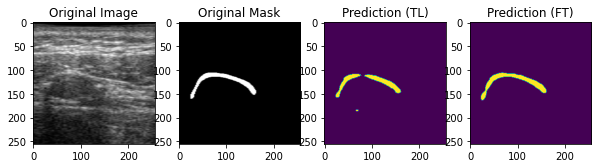

Testing image 2 : 43


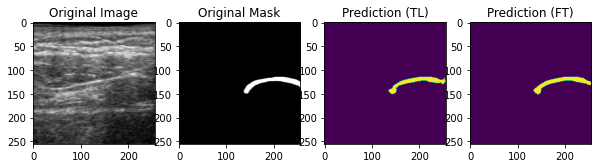

Testing image 3 : 0


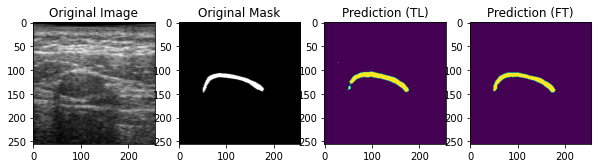

Testing image 4 : 2


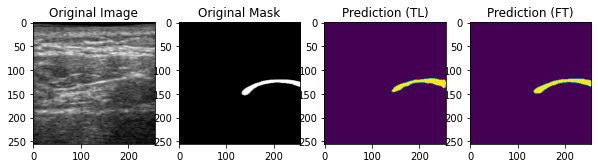

Testing image 5 : 2


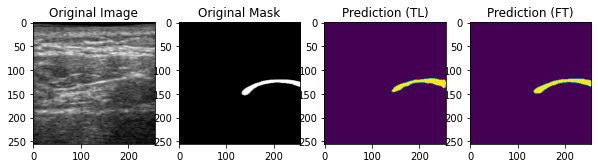

In [14]:
pred_results_ft(TLmodel, KFmodel, test_df, 5, height, width)

## 1.2. V-Unet v1_2 (pretrain and FT with 200 LUS) 

**Transfer learning model:**

In [15]:
losses = []
accuracies = []
dicecoefs = []
ious = []

checkpoint_path = 'model_v1_2/v1_2_pretrain_unet_lungseg.hdf5'

TLmodel = load_model(checkpoint_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
TLmodel.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))

results = TLmodel.evaluate_generator(evaluate_gen, 
                                    steps=len(test_df)//batch_size,
                                    verbose=1)
results = dict(zip(TLmodel.metrics_names,results))

accuracies.append(results['binary_accuracy'])
losses.append(results['loss'])
dicecoefs.append(results['dice_coef'])
ious.append(results['iou'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 139s 34s/step - loss: -0.7424 - iou: 0.5906 - dice_coef: 0.7424 - binary_accuracy: 0.9890


In [16]:
print('Evaluation scores from pretrained model:')
print('Accuracy: ', accuracies)
print('Loss: ', losses)
print('Dice coefficient: ', dicecoefs)
print('IOU: ', ious)

Evaluation scores from pretrained model:
Accuracy:  [0.9890252947807312]
Loss:  [-0.7424172163009644]
Dice coefficient:  [0.7424172163009644]
IOU:  [0.5905615091323853]


**Fine-tuning models (5Fold):**

In [ ]:
kf_losses = []
kf_accuracies = []
kf_dicecoefs = []
kf_ious = []

for k in range(5):
  kf_checkpoint_path = 'model_v1_2/' + str(k+1) + '_v1_2_finetuneKF_unet_lungseg.hdf5'
  KFmodel = load_model(kf_checkpoint_path, 
                       custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
  KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                  metrics=[iou, dice_coef, 'binary_accuracy'])
  
  # another generator for evaluate_generator 
  kf_evaluate_gen = train_generator(test_df, batch_size,
                                  None,
                                  dict(),
                                  None, None, None, None, None,
                                  (height, width))
  
  kf_results = KFmodel.evaluate_generator(kf_evaluate_gen, 
                                    steps=len(test_df)//batch_size)
  kf_results = dict(zip(KFmodel.metrics_names,kf_results))
  
  kf_accuracies.append(kf_results['binary_accuracy'])
  kf_losses.append(kf_results['loss'])
  kf_dicecoefs.append(kf_results['dice_coef'])
  kf_ious.append(kf_results['iou'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 80 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.


In [ ]:
print('Evaluation scores from 5 Fold fine-tuning model:')
print('Accuracies : ', kf_accuracies)
print('Losses : ', kf_losses)
print('Dice coefficients : ', kf_dicecoefs)
print('IOUs : ', kf_ious)

print('')

print('Average accuracy : ', np.mean(np.array(kf_accuracies)))
print('Average loss : ', np.mean(np.array(kf_losses)))
print('Average dice coefficient : ', np.mean(np.array(kf_dicecoefs)))
print('Average IOU : ', np.mean(np.array(kf_ious)))

print('')

print('SD of accuracy : ', np.std(np.array(kf_accuracies)))
print('SD of loss : ', np.std(np.array(kf_losses)))
print('SD of dice coefficient : ', np.std(np.array(kf_dicecoefs)))
print('SD of iou : ', np.std(np.array(kf_ious)))

Evaluation scores from 5 Fold fine-tuning model:
Accuracies :  [0.9907692074775696, 0.9906371831893921, 0.9906820058822632, 0.9906187057495117, 0.9905899167060852]
Losses :  [-0.7798618674278259, -0.7804239392280579, -0.7791571617126465, -0.781495213508606, -0.7727888822555542]
Dice coefficients :  [0.7798618674278259, 0.7804238796234131, 0.7791571617126465, 0.7814951539039612, 0.7727888822555542]
IOUs :  [0.6392794251441956, 0.6400455236434937, 0.638319730758667, 0.6414665579795837, 0.6298689842224121]

Average accuracy :  0.9906594038009644
Average loss :  -0.7787454128265381
Average dice coefficient :  0.7787453889846802
Average IOU :  0.6377960443496704

SD of accuracy :  6.252398707775217e-05
SD of loss :  0.003074902246794645
SD of dice coefficient :  0.003074885078933894
SD of iou :  0.004095015890040507


Predicted mask examples: 

Testing image 1 : 62


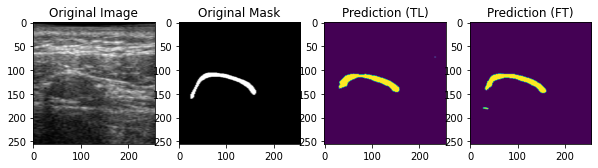

Testing image 2 : 43


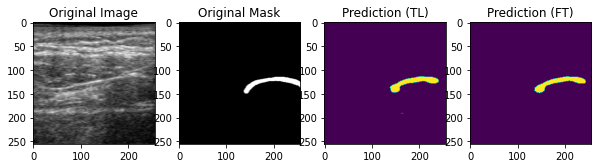

Testing image 3 : 0


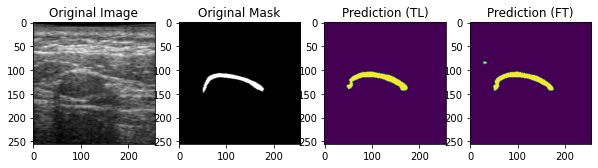

Testing image 4 : 2


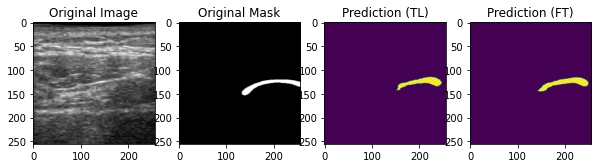

Testing image 5 : 2


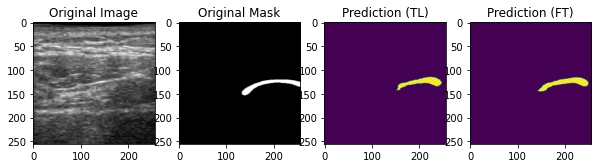

In [18]:
pred_results_ft(TLmodel, KFmodel, test_df, 5, height, width)

# 2. Evaluating X-Unet
## 2.1. X-Unet v3_3 (pre-trained with XPIE and FT with 400 LUS)
**FT strategy: FT all layers, no frozen layers**

**Fine-tuning models (5Fold):**

In [19]:
xpie_losses = []
xpie_accuracies = []
xpie_dicecoefs = []
xpie_ious = []

for k in range(5):
  XPIEmodel_path = 'model_v3_3/'+str(k+1)+'KF_finetune_localGPU_xpie_unet_lungseg_v3_3.hdf5'
  XPIEmodel = load_model(XPIEmodel_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
  XPIEmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

  evaluate_gen = train_generator(test_df, batch_size,
                                 None, 
                                 dict(),
                                None, None, None, None, None, 
                                (height, width))

  xpie_results = XPIEmodel.evaluate_generator(evaluate_gen, 
                                                      steps=len(test_df)//batch_size,
                                                      verbose=1)
  xpie_results = dict(zip(XPIEmodel.metrics_names,xpie_results))

  xpie_accuracies.append(xpie_results['binary_accuracy'])
  xpie_losses.append(xpie_results['loss'])
  xpie_dicecoefs.append(xpie_results['dice_coef'])
  xpie_ious.append(xpie_results['iou'])


print('Evaluation scores from 5 Fold fine-tuning model:')
print('Accuracies : ', xpie_accuracies)
print('Losses : ', xpie_losses)
print('Dice coefficients : ', xpie_dicecoefs)
print('IOUs : ', xpie_ious)

print('')

print('Average accuracy : ', np.mean(np.array(xpie_accuracies)))
print('Average loss : ', np.mean(np.array(xpie_losses)))
print('Average dice coefficient : ', np.mean(np.array(xpie_dicecoefs)))
print('Average IOU : ', np.mean(np.array(xpie_ious)))

print('')

print('SD of accuracy : ', np.std(np.array(xpie_accuracies)))
print('SD of loss : ', np.std(np.array(xpie_losses)))
print('SD of dice coefficient : ', np.std(np.array(xpie_dicecoefs)))
print('SD of iou : ', np.std(np.array(xpie_ious)))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 137s 33s/step - loss: -0.8283 - iou: 0.7070 - dice_coef: 0.8283 - binary_accuracy: 0.9928
Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 132s 33s/step - loss: -0.8297 - iou: 0.7091 - dice_coef: 0.8297 - binary_accuracy: 0.9927
Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 132s 33s/step - loss: -0.8299 - iou: 0.7093 - dice_coef: 0.8299 - binary_accuracy: 0.9927
Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 131s 33s/step - loss: -0.8259 - iou: 0.7035 - dice_coef: 0.8259 - binary_accuracy: 0.9927
Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 138s 33s/step - loss: -0.8258 - iou: 0.7033 - dice_coef: 0.8258 - binary_accuracy: 0.

Predicted mask examples: 

Testing image 1 : 62


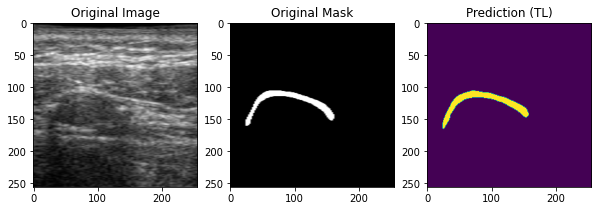

Testing image 2 : 43


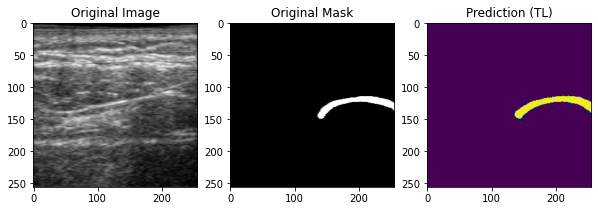

Testing image 3 : 0


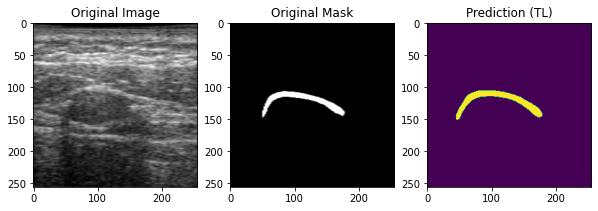

Testing image 4 : 2


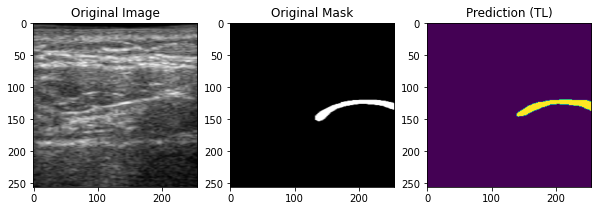

Testing image 5 : 2


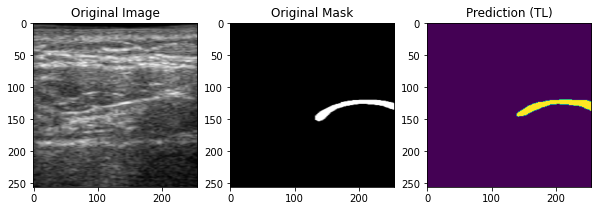

In [21]:
pred_results_tl(XPIEmodel, test_df, 5, height, width)

## 2.2. X-Unet v3_4 (pre-trained with XPIE and FT with 400 LUS)
**FT strategy: Freeze the bottleneck block**

In [7]:
XPIEmodel_path = 'model_v3_4/1KF_finetune_localGPU_xpie_unet_lungseg_v3_3.hdf5'

XPIEmodel = load_model(XPIEmodel_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
XPIEmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))

xpie_val_loss, xpie_val_iou, xpie_val_dice, xpie_val_accuracy = XPIEmodel.evaluate_generator(evaluate_gen, 
                                                      steps=len(test_df)//batch_size,
                                                      verbose=1)

print('Evaluation scores from XPIE model:')
print('Validation loss: ', xpie_val_loss)
print('Validation dice coefficient: ', xpie_val_dice)
print('Validation iou: ', xpie_val_iou)
print('Validation accuracy: ', xpie_val_accuracy)

XPIEmodel_path = 'model_v3_4/2KF_finetune_localGPU_xpie_unet_lungseg_v3_3.hdf5'

XPIEmodel = load_model(XPIEmodel_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
XPIEmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))

xpie_val_loss, xpie_val_iou, xpie_val_dice, xpie_val_accuracy = XPIEmodel.evaluate_generator(evaluate_gen, 
                                                      steps=len(test_df)//batch_size,
                                                      verbose=1)

print('Evaluation scores from XPIE model:')
print('Validation loss: ', xpie_val_loss)
print('Validation dice coefficient: ', xpie_val_dice)
print('Validation iou: ', xpie_val_iou)
print('Validation accuracy: ', xpie_val_accuracy)


XPIEmodel_path = 'model_v3_4/3KF_finetune_localGPU_xpie_unet_lungseg_v3_3.hdf5'

XPIEmodel = load_model(XPIEmodel_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
XPIEmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))

xpie_val_loss, xpie_val_iou, xpie_val_dice, xpie_val_accuracy = XPIEmodel.evaluate_generator(evaluate_gen, 
                                                      steps=len(test_df)//batch_size,
                                                      verbose=1)

print('Evaluation scores from XPIE model:')
print('Validation loss: ', xpie_val_loss)
print('Validation dice coefficient: ', xpie_val_dice)
print('Validation iou: ', xpie_val_iou)
print('Validation accuracy: ', xpie_val_accuracy)


XPIEmodel_path = 'model_v3_4/4KF_finetune_localGPU_xpie_unet_lungseg_v3_3.hdf5'

XPIEmodel = load_model(XPIEmodel_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
XPIEmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))

xpie_val_loss, xpie_val_iou, xpie_val_dice, xpie_val_accuracy = XPIEmodel.evaluate_generator(evaluate_gen, 
                                                      steps=len(test_df)//batch_size,
                                                      verbose=1)

print('Evaluation scores from XPIE model:')
print('Validation loss: ', xpie_val_loss)
print('Validation dice coefficient: ', xpie_val_dice)
print('Validation iou: ', xpie_val_iou)
print('Validation accuracy: ', xpie_val_accuracy)


XPIEmodel_path = 'model_v3_4/5KF_finetune_localGPU_xpie_unet_lungseg_v3_3.hdf5'

XPIEmodel = load_model(XPIEmodel_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
XPIEmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

evaluate_gen = train_generator(test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))

xpie_val_loss, xpie_val_iou, xpie_val_dice, xpie_val_accuracy = XPIEmodel.evaluate_generator(evaluate_gen, 
                                                      steps=len(test_df)//batch_size,
                                                      verbose=1)

print('Evaluation scores from XPIE model:')
print('Validation loss: ', xpie_val_loss)
print('Validation dice coefficient: ', xpie_val_dice)
print('Validation iou: ', xpie_val_iou)
print('Validation accuracy: ', xpie_val_accuracy)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 135s 33s/step - loss: -0.8082 - iou: 0.6782 - dice_coef: 0.8082 - binary_accuracy: 0.9916
Evaluation scores from XPIE model:
Validation loss:  -0.8081737756729126
Validation dice coefficient:  0.8081738352775574
Validation iou:  0.6782175302505493
Validation accuracy:  0.9915889501571655
Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 131s 32s/step - loss: -0.8107 - iou: 0.6819 - dice_coef: 0.8107 - binary_accuracy: 0.9919
Evaluation scores from XPIE model:
Validation loss:  -0.810693085193634
Validation dice coefficient:  0.8106930255889893
Validation iou:  0.681853175163269
Validation accuracy:  0.9918903112411499
Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 131s 32s/step - loss: -0.8107 - iou: 0.6817 - dice_coef: 0.8107 - binary_accuracy: 0.9918
E

Predicted mask examples: 

In [30]:
XPIEmodel_path = 'model_v3_3/2KF_finetune_localGPU_xpie_unet_lungseg_v3_3.hdf5'

XPIEmodel = load_model(XPIEmodel_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
XPIEmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

XPIEfzmodel_path = 'model_v3_4/2KF_finetune_localGPU_xpie_unet_lungseg_v3_3.hdf5'

XPIEfzmodel = load_model(XPIEfzmodel_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
XPIEfzmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Testing image 1 : 19


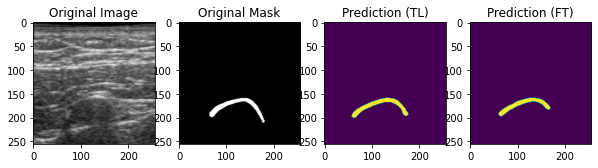

Testing image 2 : 54


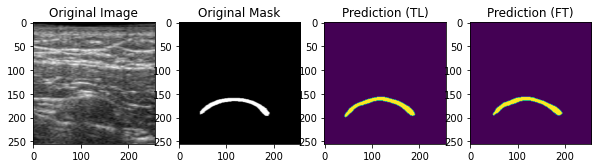

Testing image 3 : 24


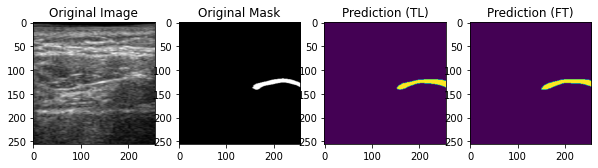

Testing image 4 : 64


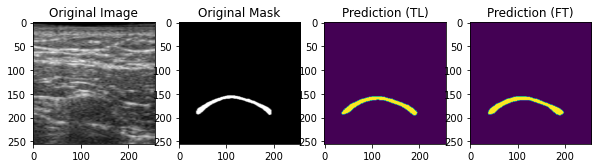

Testing image 5 : 77


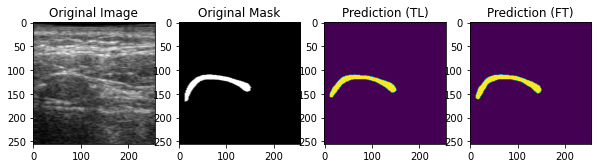

In [33]:
pred_results_ft(XPIEmodel, XPIEfzmodel, test_df, 5, height, width)

## 2.3. X-Unet v3_2 (pre-trained with XPIE and FT with 600 LUS) 
**FT strategy: FT all layers, no frozen layers**

In [35]:
xpie_losses = []
xpie_accuracies = []
xpie_dicecoefs = []
xpie_ious = []

for k in range(5):
  XPIE600model_path = 'model_v3_2/'+str(k+1)+'KF_finetune_xpie_unet_lungseg.hdf5'
  XPIE600model = load_model(XPIE600model_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
  XPIE600model.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

  evaluate_gen = train_generator(test_df, batch_size,
                                 None, 
                                 dict(),
                                None, None, None, None, None, 
                                (height, width))

  xpie_results = XPIE600model.evaluate_generator(evaluate_gen, 
                                                      steps=len(test_df)//batch_size,
                                                      verbose=1)
  xpie_results = dict(zip(XPIE600model.metrics_names,xpie_results))

  xpie_accuracies.append(xpie_results['binary_accuracy'])
  xpie_losses.append(xpie_results['loss'])
  xpie_dicecoefs.append(xpie_results['dice_coef'])
  xpie_ious.append(xpie_results['iou'])


print('Evaluation scores from 5 Fold fine-tuning model:')
print('Accuracies : ', xpie_accuracies)
print('Losses : ', xpie_losses)
print('Dice coefficients : ', xpie_dicecoefs)
print('IOUs : ', xpie_ious)

print('')

print('Average accuracy : ', np.mean(np.array(xpie_accuracies)))
print('Average loss : ', np.mean(np.array(xpie_losses)))
print('Average dice coefficient : ', np.mean(np.array(xpie_dicecoefs)))
print('Average IOU : ', np.mean(np.array(xpie_ious)))

print('')

print('SD of accuracy : ', np.std(np.array(xpie_accuracies)))
print('SD of loss : ', np.std(np.array(xpie_losses)))
print('SD of dice coefficient : ', np.std(np.array(xpie_dicecoefs)))
print('SD of iou : ', np.std(np.array(xpie_ious)))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 137s 33s/step - loss: -0.8313 - iou: 0.7115 - dice_coef: 0.8313 - binary_accuracy: 0.9929
Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 132s 33s/step - loss: -0.8298 - iou: 0.7092 - dice_coef: 0.8298 - binary_accuracy: 0.9929
Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 132s 33s/step - loss: -0.8329 - iou: 0.7138 - dice_coef: 0.8329 - binary_accuracy: 0.9929
Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 136s 34s/step - loss: -0.8344 - iou: 0.7161 - dice_coef: 0.8344 - binary_accuracy: 0.9930
Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 138s 33s/step - loss: -0.8361 - iou: 0.7185 - dice_coef: 0.8361 - binary_accuracy: 0.

Testing image 1 : 72


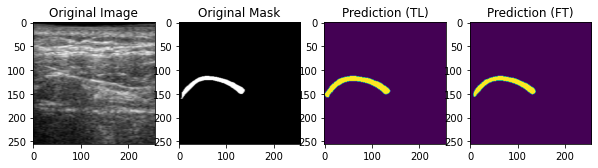

Testing image 2 : 32


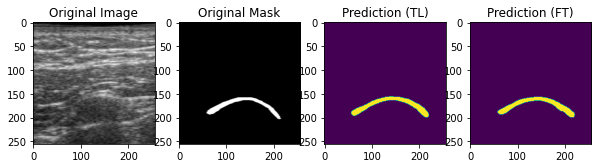

Testing image 3 : 15


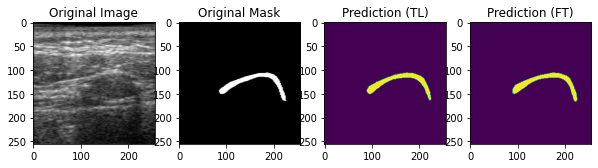

Testing image 4 : 69


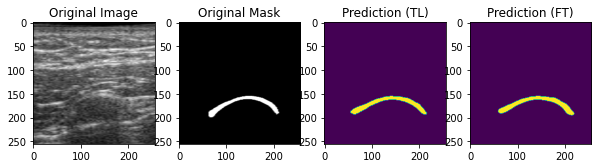

Testing image 5 : 35


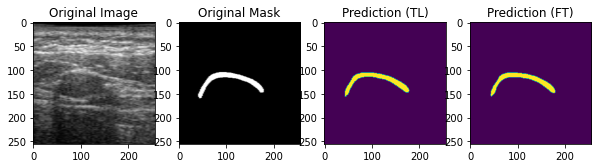

In [36]:
pred_results_ft(XPIEmodel, XPIE600model, test_df, 5, height, width)

## 3. [FAILED MODEL] Evaluating the BN1 model

**Adding Batch normalization after conv layers**

It is not included in the results since it failed to make accurate predictions, with very low DICE coefficient

In [ ]:
BN1model_path = 'modified1_models/BNpre_unet_lung_segmentation.hdf5'
BN1model = load_model(BN1model_path, 
                     custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
BN1model.compile(optimizer=Adam(lr=1e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
bn1_val_loss, bn1_val_iou, bn1_val_dice, bn1_val_accuracy = BN1model.evaluate_generator(evaluate_gen, 
                                                      steps=len(test_df)//batch_size,
                                                      verbose=1)

print('Evaluation scores from transfer learning model:')
print('Validation loss: ', bn1_val_loss)
print('Validation dice coefficient: ', bn1_val_dice)
print('Validation iou: ', bn1_val_iou)
print('Validation accuracy: ', bn1_val_accuracy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 80 validated image filenames.
Found 80 validated image filenames.
4/4 [==============================] - 150s 37s/step - loss: -0.2389 - iou: 0.1357 - dice_coef: 0.2389 - binary_accuracy: 0.8909
Evaluation scores from transfer learning model:
Validation loss:  -0.23890259861946106
Validation dice coefficient:  0.23890258371829987
Validation iou:  0.13566577434539795
Validation accuracy:  0.8909446597099304


Testing image 1 : 72


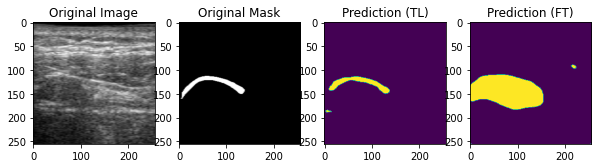

Testing image 2 : 32


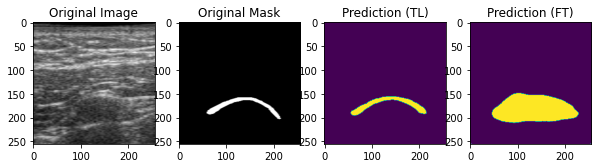

Testing image 3 : 15


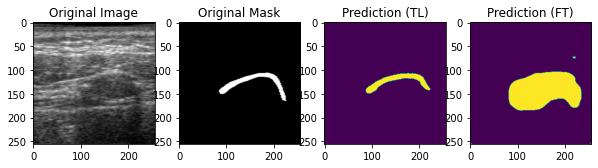

Testing image 4 : 69


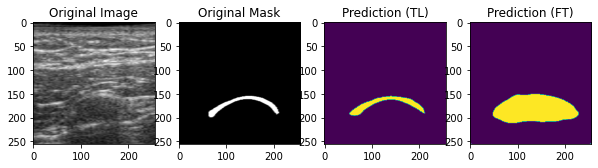

Testing image 5 : 35


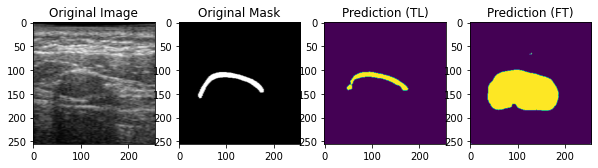

In [ ]:
pred_results_ft(TLmodel, BN1model, test_df, 5, height, width)